# Clever filtering using pytorch Module and optimizer

I didn't have good luck using my own gradient descent so I'm using this as an opportunity to learn the higher level pytorch mechanisms like `torch.nn`. This [tutorial on pytorch](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) is very good.  See work by Jeremy Howard and fastai gang: [dl1/lesson5-movielens.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb) and [fastai book: 08_collab.ipynb](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb).

## Support code

In [1]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_valid(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")

In [3]:
import pandas as pd
import re

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [4]:
def mae(y_pred, y):
    return torch.mean( (y_pred - y).abs() )

In [5]:
def train_test_split(data, test_size:float):
    n = len(data)
    n_valid = int(n*test_size)
    n_train = n - n_valid
    indices = torch.randperm(n)
    train_idx = indices[0:n_train]
    test_idx = indices[n_train:]
    train, test = data[train_idx], data[test_idx] # copying data but could not get columns out of a Subset object
    # train, valid = data, data
    X_train = train[:,[0,1]].float()
    X_test = test[:,[0,1]].float()
    y_train = train[:,2].float()
    y_test = test[:,2].float()
    return X_train, X_test, y_train, y_test

In [6]:
def top_movies(df, n=100):
    df_movies = df[['movieId','title','genres']].drop_duplicates()
    df_movies = df_movies.set_index('movieId')
    rating_count = df.groupby('movieId').count()
    top_movieIds = rating_count.sort_values(by='rating',ascending=False)[:n].index
    return df_movies.loc[top_movieIds]

In [7]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [8]:
from sklearn.decomposition import PCA

def mcolor(genre):
    if 'Comedy' in genre: return 'green'
    if 'Sci-Fi' in genre: return 'cyan'
    if 'War' in genre: return 'red'
    if 'Drama' in genre: return '#FEE08F'
    return 'black'

def plot_2D(df_movies):
    movieIds = df_movies.index.values
    titles = df_movies.loc[movieIds,'title']

    movie_embeddings = model.M[movieIds].detach().numpy()
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)

    plt.figure(figsize=(12,12))
    for i,title in enumerate(titles[:60]):
        plt.text(vecs2D[i,0], vecs2D[i,1], title)

    plt.scatter(vecs2D[:,0][:60], vecs2D[:,1][:60], s=2)

    plt.xlim(-1.1,2.5)
    plt.ylim(-1.2,1.5)
    plt.show()
    return vecs2D, titles

## Load and train with no mini-batch

In [9]:
df = load(n=100_000)
n = len(df)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
0,451,1644,4.0,"Untouchables, The",Action|Crime|Drama
1,560,1644,4.5,"Untouchables, The",Action|Crime|Drama


In [10]:
avg_rating = np.mean(df['rating'])
avg_rating

3.501345

In [11]:
import torch.nn as nn

class CollabFilter(nn.Module):
    def __init__(self, nusers, nmovies, nfactors=10, avg_rating=3.5):
        super(CollabFilter, self).__init__()
        self.U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.U = nn.Parameter(self.U) # notify pytorch these are model parameters
        self.M = nn.Parameter(self.M)
        
    def forward(self, x):
        userIds = x[:,0].long()
        movieIds = x[:,1].long()
        r_output = (self.U[userIds] * self.M[movieIds]).sum(axis=1, keepdim=False)
        r_output = torch.sigmoid(r_output) * 5  # limit to 0..5
        return r_output

In [12]:
def train(df, epochs=350, learning_rate = 0.002, nfactors=10, use_bias=False, print_every=30, loss_fn=torch.nn.MSELoss()):    
    data = torch.tensor( df[['userId','movieId','rating']].values )
    X_train, X_valid, y_train, y_valid = train_test_split(data, 0.20)
    print(f"{len(X_train)} training and {len(X_valid)} test records")

    if use_bias:
        model = CollabFilterWithBias(nusers, nmovies, nfactors=nfactors)
    else:
        model = CollabFilter(nusers, nmovies, nfactors=nfactors)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00000002) # model.parameters is just [U,M]

    history = []

    # Start history with what random weights show
    with torch.no_grad():
        loss = loss_fn(model(X_train), y_train)
        loss_valid = loss_fn(model(X_valid), y_valid)
        mae_train = mae(model(X_train), y_train).detach().item()
        mae_valid = mae(model(X_valid), y_valid).detach().item()
    history.append( (loss, loss_valid) )
    print(f"Init      L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

    for t in range(epochs):
        r_pred = model(X_train)
        loss = loss_fn(r_pred, y_train)

        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad and M.grad
        optimizer.step()

        with torch.no_grad():
            loss_valid = loss_fn(model(X_valid), y_valid)
            mae_train = mae(model(X_train), y_train).detach().item()
            mae_valid = mae(model(X_valid), y_valid).detach().item()

        history.append( (loss, loss_valid) )
        if t % print_every == 0:
            print(f"Epoch {t:3d} L2 MSE loss {loss:4.3f}, {loss_valid:4.3f}   MAE {mae_train:4.3f}, {mae_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

80000 training and 20000 test records
Init      L2 MSE loss 2.905, 2.957   MAE 1.387, 1.403
Epoch   0 L2 MSE loss 2.905, 2.909   MAE 1.374, 1.390
Epoch  30 L2 MSE loss 0.924, 0.978   MAE 0.734, 0.767
Epoch  60 L2 MSE loss 0.663, 0.801   MAE 0.614, 0.685
Epoch  90 L2 MSE loss 0.636, 0.810   MAE 0.600, 0.689
Epoch 120 L2 MSE loss 0.628, 0.818   MAE 0.594, 0.692
Epoch 150 L2 MSE loss 0.616, 0.827   MAE 0.588, 0.695
Epoch 180 L2 MSE loss 0.577, 0.834   MAE 0.568, 0.698
Epoch 210 L2 MSE loss 0.485, 0.844   MAE 0.516, 0.702
Epoch 240 L2 MSE loss 0.379, 0.880   MAE 0.450, 0.715
Epoch 270 L2 MSE loss 0.313, 0.935   MAE 0.403, 0.737
Epoch 300 L2 MSE loss 0.278, 0.985   MAE 0.375, 0.755
Epoch 330 L2 MSE loss 0.257, 1.030   MAE 0.357, 0.771


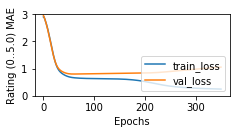

In [13]:
model, history = train(df, epochs=350, learning_rate=.01, nfactors=10)
plot_history(history, yrange=(0,3), figsize=(3.5,1.5))

## Assessing embeddings for prediction with random forest

Once we have embeddings, we can try to use them as features in a random forest. The OOB error will give us an indication of how good the embeddings are. When we get a validation MAE of 0.74 from training with n=20,000 and nfactors=10, the RF OOB R^2 is about .45, which is much better than we get using label encoded categorical variables (no better than guessing the mean with about R^2 of 0.0).

In [14]:
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

OOB R^2 0.493
Train R^2 0.930


In [16]:
model, history = train(df, epochs=350, learning_rate=.01, nfactors=4, print_every=50)
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

80000 training and 20000 test records
Init      L2 MSE loss 2.909, 2.940   MAE 1.389, 1.396
Epoch   0 L2 MSE loss 2.909, 2.911   MAE 1.381, 1.388
Epoch  50 L2 MSE loss 0.863, 0.932   MAE 0.708, 0.748
Epoch 100 L2 MSE loss 0.653, 0.790   MAE 0.609, 0.682
Epoch 150 L2 MSE loss 0.634, 0.800   MAE 0.598, 0.686
Epoch 200 L2 MSE loss 0.629, 0.813   MAE 0.594, 0.690
Epoch 250 L2 MSE loss 0.617, 0.823   MAE 0.588, 0.694
Epoch 300 L2 MSE loss 0.571, 0.832   MAE 0.564, 0.697
OOB R^2 0.440
Train R^2 0.923


In [17]:
model, history = train(df, epochs=350, learning_rate=.01, nfactors=50, print_every=50)
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu())

80000 training and 20000 test records
Init      L2 MSE loss 2.908, 2.947   MAE 1.388, 1.400
Epoch   0 L2 MSE loss 2.908, 2.837   MAE 1.358, 1.369
Epoch  50 L2 MSE loss 0.634, 0.841   MAE 0.600, 0.699
Epoch 100 L2 MSE loss 0.450, 0.833   MAE 0.491, 0.696
Epoch 150 L2 MSE loss 0.115, 0.915   MAE 0.228, 0.728
Epoch 200 L2 MSE loss 0.046, 0.995   MAE 0.130, 0.761
Epoch 250 L2 MSE loss 0.026, 1.059   MAE 0.090, 0.786
Epoch 300 L2 MSE loss 0.017, 1.113   MAE 0.069, 0.806
OOB R^2 0.469
Train R^2 0.927


## Interpretation

### Compare rating vs predicted rating visually

If we plot the known ratings against the predicted ratings, ideally we would see a 45° line. If true rating is 4.0 then we'd want the predicted rating to be 4.0.

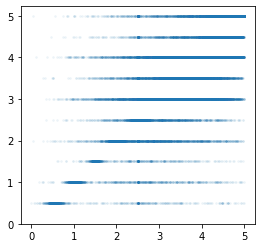

In [18]:
data = torch.tensor( df[['userId','movieId','rating']].values )
plt.figure(figsize=(4.2,4))
plt.scatter(model(data).detach().cpu(), df['rating'], alpha=.05, s=3)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

Hmm...hard to interpret, let's try a joint plot!

80000 training and 20000 test records
Init      L2 MSE loss 2.915, 2.913   MAE 1.390, 1.391
Epoch   0 L2 MSE loss 2.915, 2.804   MAE 1.359, 1.360
Epoch  50 L2 MSE loss 0.634, 0.835   MAE 0.600, 0.695
Epoch 100 L2 MSE loss 0.452, 0.827   MAE 0.493, 0.692
Epoch 150 L2 MSE loss 0.117, 0.907   MAE 0.230, 0.723
Epoch 200 L2 MSE loss 0.047, 0.989   MAE 0.131, 0.756
Epoch 250 L2 MSE loss 0.026, 1.057   MAE 0.091, 0.781
Epoch 300 L2 MSE loss 0.017, 1.112   MAE 0.069, 0.801


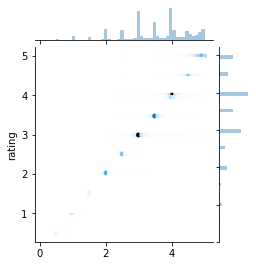

In [19]:
# I learned this jointplot trick from https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb
import seaborn

model, history = train(df, epochs=350, learning_rate=.01, nfactors=50, print_every=50)
seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=3.8)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

Try with just 10 factors

80000 training and 20000 test records
Init      L2 MSE loss 2.914, 2.917   MAE 1.390, 1.392
Epoch   0 L2 MSE loss 2.914, 2.870   MAE 1.377, 1.379
Epoch  50 L2 MSE loss 0.696, 0.800   MAE 0.633, 0.686
Epoch 100 L2 MSE loss 0.634, 0.805   MAE 0.598, 0.683
Epoch 150 L2 MSE loss 0.619, 0.820   MAE 0.590, 0.689
Epoch 200 L2 MSE loss 0.525, 0.834   MAE 0.540, 0.695
Epoch 250 L2 MSE loss 0.358, 0.916   MAE 0.436, 0.724
Epoch 300 L2 MSE loss 0.282, 1.017   MAE 0.378, 0.761


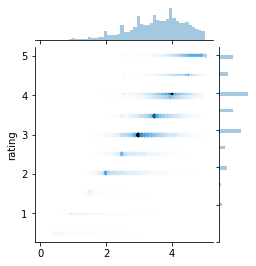

In [20]:
model, history = train(df, epochs=350, learning_rate=.01, nfactors=10, print_every=50)
seaborn.jointplot(model(data).detach().cpu(), df['rating'], kind='hex', height=3.8)
plt.xticks(range(6))
plt.yticks(range(6))
plt.show()

It looks to me like the embedding with 50 dimensions gets a tighter mapping (45° line) than 10 dimensional embedding vectors.

## Model with biases

In [21]:
import torch.nn as nn

class CollabFilterWithBias(nn.Module):
    def __init__(self, nusers, nmovies, nfactors=10, avg_rating=3.5):
        super(CollabFilterWithBias, self).__init__()
        self.U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True,
                       std=0.01, mean=math.sqrt(avg_rating/nfactors))
        self.U_bias = randn(nusers,  1,        device=device, dtype=dtype, requires_grad=True,
                      std=0.01, mean=avg_rating/nfactors)
        self.M_bias = randn(nmovies, 1,        device=device, dtype=dtype, requires_grad=True,
                      std=0.01, mean=avg_rating/nfactors)
        # Indexing is tricky; took me a while to interpret everything properly for visualization
        # The movie and user IDs are used as indexes into the U, M, and bias tensors so they are
        # inherently ordered by move or user ID. M_bias[13] is the bias for movie ID 13
        self.U = nn.Parameter(self.U) # notify pytorch these are model parameters
        self.M = nn.Parameter(self.M)
        self.U_bias = nn.Parameter(self.U_bias)
        self.M_bias = nn.Parameter(self.M_bias)
        
    def forward(self, x):
        userIds = x[:,0].long()
        movieIds = x[:,1].long()
        r_output = (self.U[userIds] * self.M[movieIds]).sum(axis=1)
        bias = (self.U_bias[userIds] + self.M_bias[movieIds]).reshape(len(x))
        r_output = r_output
        r_output += bias
        r_output = torch.sigmoid(r_output) * 5  # limit to 0..5
        return r_output

In [22]:
model, history = train(df, epochs=400, learning_rate = 0.01, nfactors=50, use_bias=True, print_every=50)

80000 training and 20000 test records
Init      L2 MSE loss 2.962, 2.984   MAE 1.403, 1.412
Epoch   0 L2 MSE loss 2.962, 2.878   MAE 1.373, 1.383
Epoch  50 L2 MSE loss 0.607, 0.795   MAE 0.589, 0.684
Epoch 100 L2 MSE loss 0.429, 0.775   MAE 0.481, 0.674
Epoch 150 L2 MSE loss 0.117, 0.858   MAE 0.231, 0.704
Epoch 200 L2 MSE loss 0.047, 0.944   MAE 0.131, 0.739
Epoch 250 L2 MSE loss 0.026, 1.008   MAE 0.091, 0.764
Epoch 300 L2 MSE loss 0.017, 1.059   MAE 0.070, 0.783
Epoch 350 L2 MSE loss 0.012, 1.102   MAE 0.056, 0.799


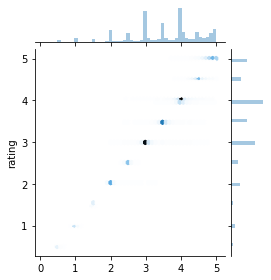

In [23]:
data = torch.tensor( df[['userId','movieId','rating']].values )
r_pred = model(data).detach().cpu().numpy()

g = seaborn.jointplot(r_pred, df['rating'], kind='hex', height=4)
plt.show()

In [24]:
RF_valid(df, model.M.detach().cpu(), model.U.detach().cpu()) # NO biases

OOB R^2 0.453
Train R^2 0.925


In [25]:
M = model.M.detach().cpu().numpy()
U = model.U.detach().cpu().numpy()
M_bias = model.M_bias.detach().cpu().numpy()
U_bias = model.U_bias.detach().cpu().numpy()
M.shape, U.shape, M_bias.shape, U_bias.shape

((9690, 50), (610, 50), (9690, 1), (610, 1))

In [26]:
RF_valid(df, M+M_bias, U+U_bias) # USE biases

OOB R^2 0.451
Train R^2 0.925


If anything, using bias seems to reduce RF predictive ability. weird.

### Interpretation of biases

Another trick from fastai book is to look at biases. Each movie (and each user) has a bias value computed during training. The movie bias adjusts the rating computed from the dot product of a movie and user in the training set to get it closer to the known rating. Let's start by looking at the top movies sorted by overall rating. Note that this rating does not say how good a movie is per se. It says: of those that have (self filtered to have) seen this movie, how did they rate the movie?

In [27]:
topN = 2_000
df_top_movies = top_movies(df, n=topN)
df_top_movies.head(3)

,title,genres
movieId,,
314,Forrest Gump,Comedy|Drama|Romance|War
277,"Shawshank Redemption, The",Crime|Drama
257,Pulp Fiction,Comedy|Crime|Drama|Thriller


The top rated movie is Forrest Gump. The people that have seen it seemed to really like it. It doesn't say that the features of the movie would in any way overlap with anySpecific individual's interests, however.

In [28]:
len(df_top_movies), model.M.shape, model.M_bias.shape

(2000, torch.Size([9690, 50]), torch.Size([9690, 1]))

In [29]:
# M_bias at i is movie ID i
df_top_movies['movie_bias'] = model.M_bias[df_top_movies.index.values].detach().numpy()
df_top_movies.head(5)

,title,genres,movie_bias
movieId,,,
314,Forrest Gump,Comedy|Drama|Romance|War,0.289581
277,"Shawshank Redemption, The",Crime|Drama,0.443922
257,Pulp Fiction,Comedy|Crime|Drama|Thriller,0.414124
510,"Silence of the Lambs, The",Crime|Horror|Thriller,-0.055161
1938,"Matrix, The",Action|Sci-Fi|Thriller,0.043495


In [30]:
df_top_movies.sort_values('movie_bias', ascending=True).head(8)

,title,genres,movie_bias
movieId,,,
637,Kazaam,Children|Comedy|Fantasy,-0.885285
2183,Phantasm,Horror|Sci-Fi,-0.800380
7151,2012,Action|Drama|Sci-Fi|Thriller,-0.747342
3399,Planet of the Apes,Action|Adventure|Drama|Sci-Fi,-0.745389
230,Major Payne,Comedy,-0.743860
1742,I Still Know What You Did Last Summer,Horror|Mystery|Thriller,-0.738760
130,Canadian Bacon,Comedy|War,-0.714237
454,RoboCop 3,Action|Crime|Drama|Sci-Fi|Thriller,-0.714071


"Kazaam" (for this run) seems to have the most negative bias, meaning that to match the ratings given by the users for this movie, the model had to downward shift the rating predicted by overlap of interests.

In [31]:
df_top_movies.sort_values('movie_bias', ascending=False).head(8)

,title,genres,movie_bias
movieId,,,
899,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,0.749778
5924,Serenity,Action|Adventure|Sci-Fi,0.733076
7858,Moonrise Kingdom,Comedy|Drama|Romance,0.728449
4897,Hellboy,Action|Adventure|Fantasy|Horror,0.672095
1157,"Fifth Element, The",Action|Adventure|Comedy|Sci-Fi,0.661768
1797,Miracle on 34th Street,Comedy|Drama,0.641954
7706,Hugo,Children|Drama|Mystery,0.627448
1396,Buffalo '66 (a.k.a. Buffalo 66),Drama|Romance,0.611100


"Raiders" apparently gets a boost to indicate people like it.

The fastai book points out quite nicely that movies with very negative biases mean that people don't like them, even when the movie x user dot product gives the movie a high score (a high score indicates they are likely to enjoy that movie based on the latent features).  For the really positive bias movies, such as 0.9593 bias, that indicates that even if the movie is not a good fit for you, you might like it because it gives you almost a full star boost because it is that good. Of course, it is also the case that poorly matched movies with low bias predicts a really bad experience watching the movie.  Naturally we should recommend to people movies that have both high product and high bias.

### Project 50D embeddings onto 2D

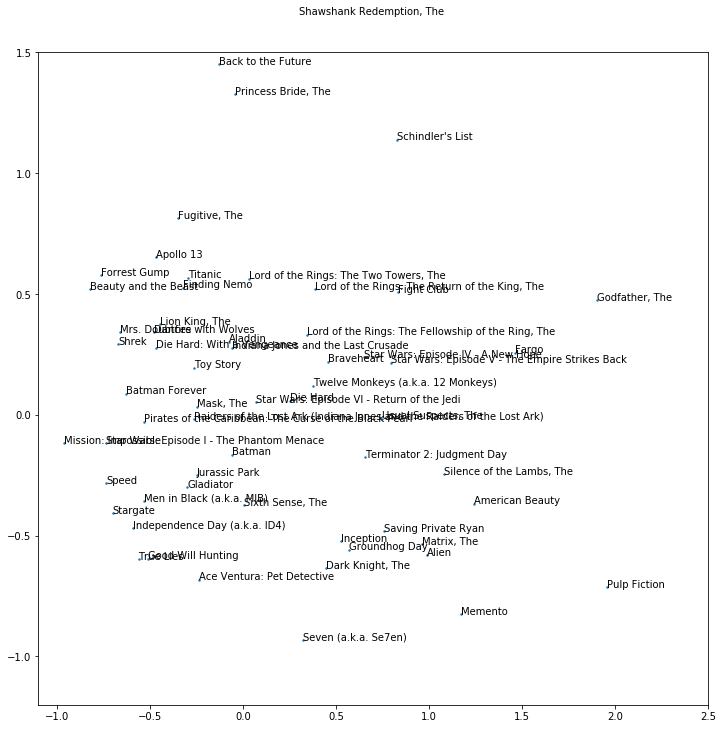

In [32]:
vecs2D, titles = plot_2D(df_top_movies[:500])

We can see that the Lord of the rings movies are more or less right on top of each other and so are the Star Wars movies.

In [33]:
movieIds = df_top_movies[:500].index.values
titles = df_top_movies.loc[movieIds,'title']

movie_embeddings = model.M[movieIds].detach().numpy()
pca = PCA(n_components=3) # <-- 3 not 2
vecs2D = pca.fit_transform(movie_embeddings)
df_sort = df_top_movies[:500].copy()
df_sort['f1'] = vecs2D[:,0]
df_sort['f2'] = vecs2D[:,1]
df_sort['f3'] = vecs2D[:,2]
df_sort

,title,genres,movie_bias,f1,f2,f3
movieId,,,,,,
314,Forrest Gump,Comedy|Drama|Romance|War,0.289581,-0.762053,0.578760,0.963057
277,"Shawshank Redemption, The",Crime|Drama,0.443922,0.302226,1.656597,-0.192761
257,Pulp Fiction,Comedy|Crime|Drama|Thriller,0.414124,1.958501,-0.712206,0.364429
510,"Silence of the Lambs, The",Crime|Horror|Thriller,-0.055161,1.078384,-0.244830,-0.282845
1938,"Matrix, The",Action|Sci-Fi|Thriller,0.043495,0.959686,-0.535785,0.463830
...,...,...,...,...,...,...
4831,The Butterfly Effect,Drama|Sci-Fi|Thriller,-0.282619,-0.113282,0.358868,0.736501
3657,M*A*S*H (a.k.a. MASH),Comedy|Drama|War,0.281121,0.199322,-0.136246,-0.195081
4002,"Ring, The",Horror|Mystery|Thriller,0.100842,-0.091383,0.009919,-0.473741


Sort movies by the projected dimension. It looks like the first dimension is a spectrum of maybe comedy/light on one side and violence on the other.  The second dimension might be action versus romance drama. I don't see a pattern for the third dimension.

In [34]:
df_sort.sort_values(by='f1')[['title','genres']]

,title,genres
movieId,,
376,City Slickers II: The Legend of Curly's Gold,Adventure|Comedy|Western
3869,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Action|Comedy|Sci-Fi
1939,10 Things I Hate About You,Comedy|Romance
3274,Legally Blonde,Comedy|Romance
4,Father of the Bride Part II,Comedy
...,...,...
602,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
6279,Borat: Cultural Learnings of America for Make ...,Comedy
900,Brazil,Fantasy|Sci-Fi


In [35]:
df_sort.sort_values(by='f2')[['title','genres']]

,title,genres
movieId,,
1260,Starship Troopers,Action|Sci-Fi
2299,Dogma,Adventure|Comedy|Fantasy
1622,Blade,Action|Horror|Thriller
2636,American Psycho,Crime|Horror|Mystery|Thriller
1180,Face/Off,Action|Crime|Drama|Thriller
...,...,...
692,Some Like It Hot,Comedy|Crime
792,"Sound of Music, The",Musical|Romance
907,To Kill a Mockingbird,Drama


In [36]:
df_sort.sort_values(by='f3')[['title','genres']]

,title,genres
movieId,,
4410,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
3623,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
4780,"Lord of the Rings: The Return of the King, The",Action|Adventure|Drama|Fantasy
1430,Rocky,Drama
690,North by Northwest,Action|Adventure|Mystery|Romance|Thriller
...,...,...
3222,A.I. Artificial Intelligence,Adventure|Drama|Sci-Fi
6298,"Prestige, The",Drama|Mystery|Sci-Fi|Thriller
1729,Life Is Beautiful (La Vita è bella),Comedy|Drama|Romance|War


## Lessons

Make sure that you have a valid way to assess your model before you start. I spent many hours chasing a bad model that in fact was simply a bad assessment.

With about 10,000 movies, most of them you will not of heard of. So if you try to show a PCA projection or top bias movies or something like that, you will likely see a bunch of movies you don't know. I dropped it down to 2000 for visualization purposes but not training.

It seems that driving the training score very low gives me a much tighter joint plot; this is despite the fact that the validation error was going up.